# CNNs in Python

**Objectives**
- Use Keras to build a CNN to classify image data.

### Imports, Loading, Functions

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

In [2]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()
    return fig, axes

In [3]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', values_format="d", colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, values_format=".2f", colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

In [4]:
# Import the mnist data from Keras
from tensorflow.keras.datasets import mnist
# Get data - it is already split into training and testing sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


### Formatting, Preparing Data

In [5]:
# Check shape of data
X_train.shape

(60000, 28, 28)

We have 60,000 images in the training data.  Currently, each image is 28 pixels by 28 pixels. Since each pixel only has one value, we need to reshape this to be 28x28x1. We must reshape both our X_train and X_test.

In [6]:
# Reshape data
X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]

In [7]:
# Confirming new shape
X_train.shape

(60000, 28, 28, 1)

We will scale our X data by adding a scaling layer to our model in a future step.

Explore the format of the y data.

In [8]:
# Viewing the first label in original y_train
y_train[0]

5

Since our target is numeric (0, 1, 2, 3, etc.), our computer will recognize the higher digits as having a higher numeric value and will treat classifying a 1 as a 2 as closer to the correct value than classifying a 1 as a 9. However, all we are doing in this problem is classifying, so the values of the digits are irrelevant. We could just as easily have strings here, such as "one," "two," "three," etc... Thus, we also need to convert our target into a category. Thankfully, Keras makes this easy for us using the to_categorical class.​

Now, we will encode both the y-train and test values.

In [9]:
# Create One-Hot-Encoded target for Tensorflow
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

### Building a CNN

Building a CNN will follow the same process as dense neural networks from previous lessons.
1. Build network structure
2. Compile
3. Fit

#### 1. Build Network Structure

In [10]:
# Step 1: Define our network structure
# Save the input shape (skip the number of images)
input_shape = X_train.shape[1:]
input_shape

(28, 28, 1)

In [11]:
# Next, instantiate the model
# Sequential model
model = Sequential()

Next, start adding layers. Start with a scaling layer to scale the data within the model.

In [12]:
from tensorflow.keras import layers
# Using rescaling layer to scale pixel values
scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
model.add(scaling_layer)

Next, we will add:
- A Convolutional layer: we used 8 filters and a kernel size of 3.
- A Pooling Layer: we used a pool_size of 2

In [13]:
# Convolutional layer
model.add(
    Conv2D(
        filters=8,  # How many filters you want to use
        kernel_size=3,  # size of each filter
        input_shape=input_shape,  # What is the shape of your input features (we defined this above)
    )
) 
# Pooling layer
model.add(MaxPooling2D(pool_size=2))  # Size of pooling

Next, we will add:
- A Flattening Layer
- The Output Layer: this is a multiclass classification with ten classes, so we will use ten nodes and softmax.

In [14]:
# Flattening layer
model.add(Flatten())
# Output layer
model.add(
    Dense(10, activation="softmax")  # How many output possibilities we have
)  # What activation function are you using?

In [15]:
# Check model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 8)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1352)              0         
                                                                 
 dense (Dense)               (None, 10)                13530     
                                                                 
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
____________________________________________________

#### 2. Compile

Since this is a multiclass classification problem, we will use categorical cross-entropy as our loss function. We can also track the accuracy over time by specifying this in the metrics parameter.

In [16]:
# Step 2: Compile
model.compile(loss="categorical_crossentropy", optimizer="adam", 
              metrics=["accuracy"])

#### 3. Fit

Now, we will fit the model. We will use a validation split to preserve our testing data for the final evaluation.

In [17]:
# Step 3: Fit our model
history = model.fit(X_train, y_train, 
                    validation_split=.2,
                    epochs=10)

Epoch 1/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3834 - accuracy: 0.8930 - val_loss: 0.2328 - val_accuracy: 0.9345
Epoch 2/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2073 - accuracy: 0.9411 - val_loss: 0.1773 - val_accuracy: 0.9501
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1511 - accuracy: 0.9577 - val_loss: 0.1445 - val_accuracy: 0.9613
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1216 - accuracy: 0.9651 - val_loss: 0.1208 - val_accuracy: 0.9664
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1023 - accuracy: 0.9706 - val_loss: 0.1122 - val_accuracy: 0.9688
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0894 - accuracy: 0.9744 - val_loss: 0.0996 - val_accuracy: 0.9721
Epoch 7/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0796 - accuracy: 0.9768 - val_loss: 0.1037 - val_accuracy:

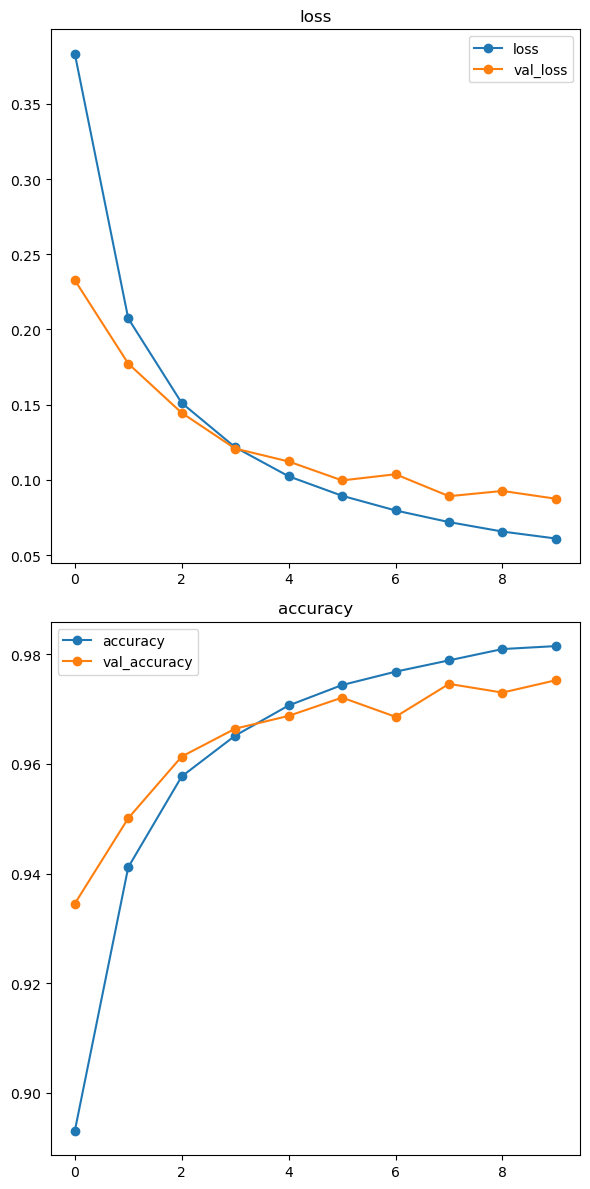

In [18]:
# Call custom function to plot metrics
plot_history(history);

In [19]:
# Evaluate model with unseen data
model.evaluate(X_test, y_test, return_dict=True)

313/313 [==============================] - 1s 2ms/step - loss: 0.0828 - accuracy: 0.9742


{'loss': 0.0827585980296135, 'accuracy': 0.9742000102996826}

Our model has 97% accuracy. (Due to the randomness inherent in the code, your results may vary)

We can also obtain our familiar sklearn results using our custom function.

First, note the format of our predictions

In [20]:
# Get predictions for sklearn metrics
y_test_pred = model.predict(X_test)
y_test_pred[0]

313/313 [==============================] - 1s 1ms/step


array([1.1376452e-07, 6.1650792e-07, 7.4749784e-07, 1.2669142e-04,
       3.4300957e-08, 1.0917192e-08, 5.5282059e-13, 9.9987090e-01,
       2.9723572e-09, 8.3330502e-07], dtype=float32)

These values are the probability that the digit falls within the particular class (digits 0-9). If we sum these values, it should be approximately equal to 1.

In [21]:
# Sum all the values for the first prediction
sum(y_test_pred[0])

0.9999999470244739

In [22]:
# The highest value corresponds with the final prediction
# Find the max value
max(y_test_pred[0])

0.9998709

The highest probability is 99.99%, but now, we need to find the index associated with the max value to obtain the actual digit that is predicted. For this, we can use argmax()

In [23]:
# Find index at the max value
y_test_pred[0].argmax()

7

Now, we have the prediction in a format sklearn can understand.

We will convert all the probability values to the class using .argmax when we call our custom function.

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.99      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.96      0.98      0.97       892
           6       0.98      0.97      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.96      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



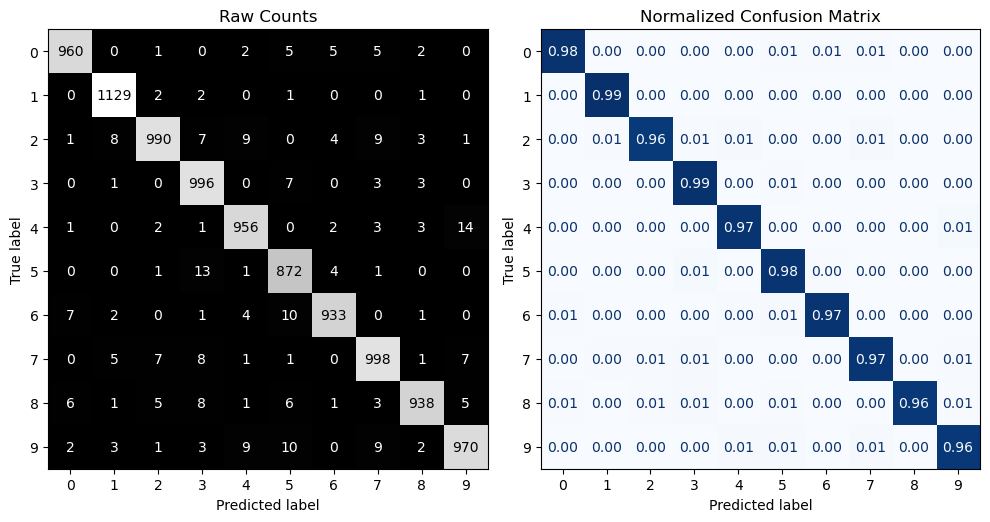

In [24]:
# Getting Sklearn Metrics
classification_metrics(y_test.argmax(axis=1), y_test_pred.argmax(axis=1),
                          label='Test Data',
                         figsize=(10,8))

We now have some insight into the challenges the model is facing. For example, it sometimes confuses 7s and 2s or confuses 4s and 9s. Overall, the accuracy is 97%.

### Summary

In this lesson, we demonstrated using a CNN to make predictions for a multiclass image classification task. We had to address the formatting of both the X and y data. To obtain our familiar sklearn evaluation metrics, we had to ensure our predictions were interpretable by sklearn. In the next lesson, we will explore Tensorflow Dataset objects.

